In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('20181004-1536welltest.txt',
                  skiprows =[0,1,2,3,4,5])

wells = data.loc[:,'Unnamed: 0':'Unnamed: 1']
layout = pd.read_csv('20181015-1536PlateLayout3.csv')

wells['Unnamed: 0'] = wells['Unnamed: 0'].str.replace(r'[a]', 'AA')
wells['Unnamed: 0'] = wells['Unnamed: 0'].str.replace(r'[b]', 'AB')
wells['Unnamed: 0'] = wells['Unnamed: 0'].str.replace(r'[c]', 'AC')
wells['Unnamed: 0'] = wells['Unnamed: 0'].str.replace(r'[d]', 'AD')
wells['Unnamed: 0'] = wells['Unnamed: 0'].str.replace(r'[e]', 'AE')
wells['Unnamed: 0'] = wells['Unnamed: 0'].str.replace(r'[f]', 'AF')
wells['Unnamed: 0'] = wells['Unnamed: 0'].str.lower()
wells = wells['Unnamed: 0'].str.cat(wells['Unnamed: 1'].astype(str))

### The well names came off the platereader weird so this corrects them



data = data.loc[:,'Unnamed: 2':].drop('Unnamed: 584', 
                              axis = 1)
name = pd.read_csv('20181004-1536welltest.txt',
                  nrows =3)['User: USER'][1]


data = data.where(data['Unnamed: 2'] != 'unused ').dropna()
data = data.rename(data['Unnamed: 2']).drop(['Unnamed: 2'],
                                    axis = 1)

data = data.subtract(data['800'],
             axis = 0)
data.columns = data.columns.astype(int)
data.index= wells


### remove dud wells (bad dispensing ones)
data = data.loc[data[418]<0.07]
trimmed = data.loc[:,'350':'800']
'''
#### This bit plots specific runs
xlayout = layout.loc[layout['index'] > 0]
xlayout = xlayout.sort_values('Substrate/nl')
xdata = data.loc[xlayout['0']]
trimmed = xdata.loc[:,'350':'800']
'''


fig, ax = plt.subplots(figsize=(15,5))
ax.set_prop_cycle('color',plt.cm.inferno(np.linspace(0,0.9,len(trimmed))))

for i in range(0,len(trimmed)):
    plt.plot(trimmed.iloc[i,:],
                lw = 1, alpha = 0.8)

#plt.title('P450 BM3 Wild Type and Fatty Acids in a 1536 well Plate')    
plt.xticks(np.linspace(350,800,10))
plt.ylabel('Absorbance', size = 15)
plt.xlabel('Wavelength/nm', size = 15)
plt.axis(xmin = 350, xmax = 800, ymax = 0.2)

plt.show()

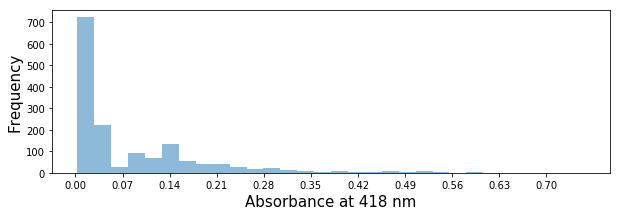

In [33]:
plt.figure(figsize =(10,3))
plt.hist(data[418], bins = 30, alpha = 0.5)
plt.xticks(np.linspace(0,0.7,11))
plt.xlabel('Absorbance at 418 nm', size = 15)
plt.ylabel('Frequency', size = 15)

plt.show()

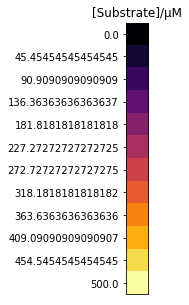

In [129]:
fig, ax = plt.subplots(figsize=(5,5))
plt.set_cmap('inferno')
plt.imshow(pd.DataFrame(np.linspace(0,0.9,12)),
          aspect = 1)
plt.xticks([])
plt.yticks(np.arange(0,12))

ax.set_yticklabels(labels = np.linspace(0,500,12), y = np.linspace(0,500,12))
plt.title('[Substrate]/µM')


plt.show()

# Trying to fit a curve to anomalies

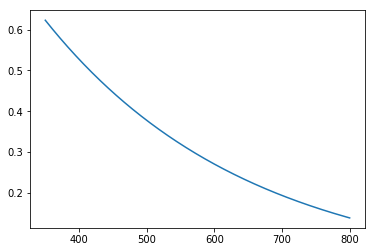

NameError: name 'coefs' is not defined

In [119]:
def anomalycurve(x,y,k1):
    y = np.exp(x/k1)
    return y
def fitanomalycurve(x,y):
     params = optimize.curve_fit(anomalycurve, x,y, p0=[1,1], maxfev =10000)
        
     return params

y = trimmed.iloc[0,:]
x = y.index.values
#coefs = fitanomalycurve(x,y)

plt.plot(x,(2*np.exp(-x/300)))
plt.show()
print(coefs)

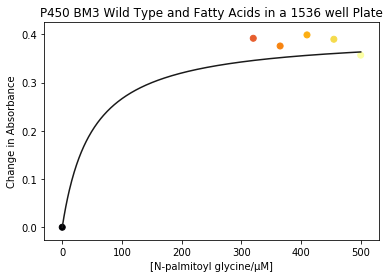

In [35]:
from scipy import optimize
layout = pd.read_csv('20181015-1536PlateLayout3.csv')


def curve(x, vmax, km):
    y = (vmax*x)/(km + x)
    return y

def getkd(run, layout, data):
    xlayout = layout.loc[layout['index'] == run]
    xlayout = xlayout.sort_values('Substrate/nl')
    xdata = data.loc[xlayout['0']]
    xdata = xdata - xdata.loc[xlayout['0'].iloc[0]]
    xdata = xdata.loc[:,350:450]
    diffdiff = xdata.max(axis = 1)-xdata.min(axis = 1)
    mmx = pd.concat([xlayout['Substrate/nl'].reset_index(drop=True),
                     diffdiff.reset_index(drop=True)], axis = 1,
                   join = 'inner')
    params, cov = optimize.curve_fit(curve, mmx['Substrate/nl'], mmx[0], p0=[1,1])
    vmax = params[0]
    km = params[1]                                                                                                            

    
    return mmx
#kds = pd.DataFrame([getkd(i,layout, data) for i in layout['index'].unique()])
#kds.sort_values([0], ascending = False)


sixty = getkd(60,layout, data)
params, cov = optimize.curve_fit(curve, sixty['Substrate/nl'], sixty[0], p0=[1,1])
#Theoretical Curve
vmax = params[0]
km = params[1]
x2 = np.linspace(0,sixty['Substrate/nl'].max(), 500)
y2 = curve(x2, 0.4, 50)

plt.set_cmap('inferno')
plt.plot(x2, y2,color = '0.1')
plt.scatter(sixty['Substrate/nl'], sixty[0],
           c = sixty['Substrate/nl'])
plt.title('P450 BM3 Wild Type and Fatty Acids in a 1536 well Plate')    
plt.ylabel('Change in Absorbance')
plt.xlabel('[N-palmitoyl glycine/µM]')
plt.show()

In [36]:
sixty

,Substrate/nl,0
0,0.0,0.000
1,320.0,0.392
2,365.0,0.376
3,410.0,0.399
4,455.0,0.390
5,500.0,0.357


C:\Users\MFBX3JE3\Anaconda35\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


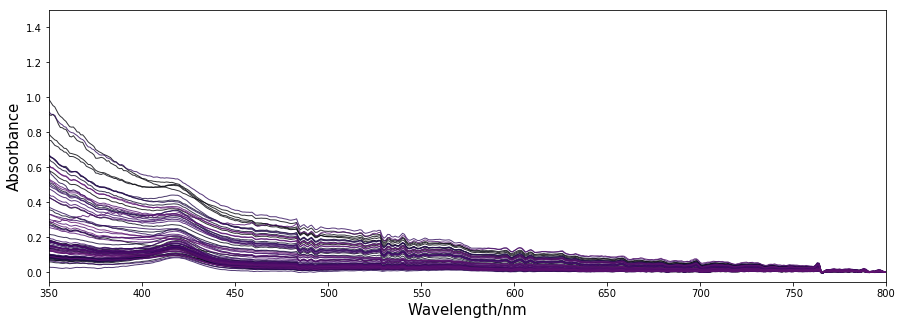

In [47]:
#layout[layout['Substrate/nl'] == 0]['0']
zeroconcs = data.loc[list(layout[layout['Substrate/nl'] == 0]['0'])].dropna()
zeroconcs = zeroconcs.loc[:,'350':'800']


fig, ax = plt.subplots(figsize=(15,5))
ax.set_prop_cycle('color',plt.cm.inferno(np.linspace(0,0.9,len(trimmed))))

for i in range(0,len(zeroconcs)):
    plt.plot(trimmed.iloc[i,:],
                lw = 1, alpha = 0.8)

#plt.title('P450 BM3 Wild Type and Fatty Acids in a 1536 well Plate')    
plt.xticks(np.linspace(350,800,10))
plt.ylabel('Absorbance', size = 15)
plt.xlabel('Wavelength/nm', size = 15)
plt.axis(xmin = 350, xmax = 800, ymax = 1.5)

plt.show()

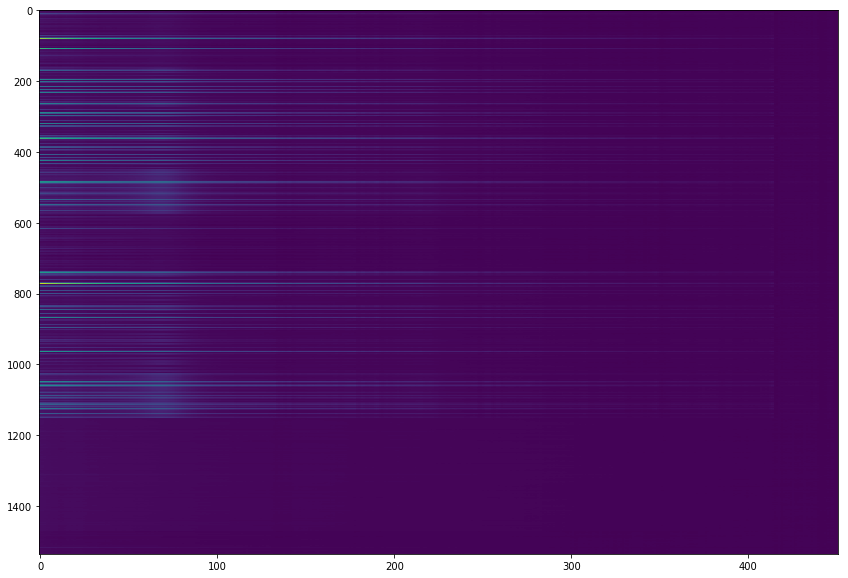

In [50]:
plt.figure(figsize = (40,10))
plt.imshow(trimmed,
          aspect = 0.2)
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

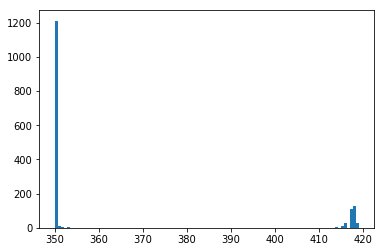

In [346]:
plt.hist(trimmed.idxmax(axis = 1),
        bins = 100)
plt.show

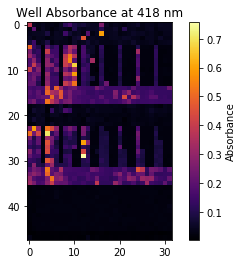

In [208]:
platemax418 = np.reshape(np.array(data.loc[:,418]),newshape  = (48,32))

plt.set_cmap('inferno')
plt.imshow(platemax418)
plt.title('Well Absorbance at 418 nm')
plt.colorbar(label = 'Absorbance')

plt.show()